# Model explainability

In this notebook, we demonstrate how to load a trained model from the [model training demo](prd_demo_fraction_model_spice.ipynb) and apply explainable AI techniques to better understand predictions being made by the ML model.

This demo provides examples of:
- Visualisation of filters in 1D convolutional neural networks
- Permutation feature importance
- Saliency maps

To start, import relevant libraries

In [ ]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import mlflow

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import prd_pipeline

AzureML libraries not found, using local execution functions.


### Set up MLFlow and load pretrained model

This demo will be using an existing model, created in the [model training notebook](prd_demo_fraction_model_spice.ipynb). This will be loaded in from the MLFlow experiment.

In [ ]:
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: file:///net/home/h02/hbrown/code/git/precip_rediagnosis/model_pipeline/mlruns


The run_id is required to load the pretrained model from MLFlow. The run_id for each experiment run tracked using MLFlow can be found via the MLFlow user interface (launched by running ```mlflow ui``` in the command line). Once the run_id is know, we can easily load in models trained for previous experiments for inference and evaluation.

In [ ]:
run_id = 'a3360154e69047af8933fe4c44974f40'
model = mlflow.keras.load_model(f'runs:/{run_id}/model')

2022-12-20 12:58:12.954662: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Test data set up and loading and preprocess test data

The data set up here should be the same as the set up from model training, including the same set of precipitation intensity bands and the same model input features.

In [ ]:
bands = {
    '0.0':[0, 0.01],
    '0.25':[0.01, 0.5], 
    '2.5': [0.5, 4], 
    '7.0':[4, 10], 
    '10.0':[10,220]
}

In [ ]:
intensity_band_template = '{source}_fraction_in_band_instant_{band_centre}'

In [ ]:
target_parameter = [intensity_band_template.format(source='radar', band_centre=threshold) for threshold in bands.keys()]
nwp_comparison = [intensity_band_template.format(source='mogrepsg', band_centre=threshold) for threshold in bands.keys()]

profile_features = ['air_temperature', 'relative_humidity',  'wind_speed', 'wind_from_direction', 'cloud_volume_fraction'] #air_pressure',
single_lvl_features = []#['surface_altitude']#'thickness_of_rainfall_amount', 'surface_altitude', 'air_pressure_at_sea_level', 'cloud_area_fraction'

In [ ]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
    'nwp': nwp_comparison, 
    'metadata': ['time', 'realization', 'latitude', 'longitude']
} 

In [ ]:
data_dims_dict = {
    'nprof_features': len(profile_features), 
    'nheights': 33, 
    'nsinglvl_features': len(single_lvl_features), 
    'nbands': len(bands)
}

We then load the test scenario dataset into pandas DataFrames. Here, test_scenario can currently be set to either 'storm_ciara' or 'storm_eunice_franklin' (but can be set to any event name that has been left out of the model training dataset)

In [ ]:
dataset_dir = '/project/informatics_lab/precip_rediagnosis/train_202212'
dataset_dir = pathlib.Path(dataset_dir)

prd_path_list = [p1 for p1 in dataset_dir.rglob(f'{prd_pipeline.MERGED_PREFIX}*{prd_pipeline.CSV_FILE_SUFFIX}')]

In [ ]:
test_scenario_name = 'storm_eunice' 
test_scenario_filepath = [event for event in prd_path_list if test_scenario_name in str(event)][0]
test_scenario_filepath

PosixPath('/project/informatics_lab/precip_rediagnosis/train_202212/2022_storm_eunice_franklin/prd_merged_20220218T1200Z_20220221T1200Z.csv')

In [ ]:
test_scenario = pd.read_csv(test_scenario_filepath)
test_scenario.head()

,time,latitude,longitude,radar_max_rain_aggregate_3hr,radar_mean_rain_aggregate_3hr,radar_max_rain_instant,radar_mean_rain_instant,fraction_sum_agg,fraction_sum_instant,radar_fraction_in_band_aggregate_3hr_0.0,...,wind_speed_2750.0,wind_speed_3000.0,wind_speed_3250.0,wind_speed_3500.0,wind_speed_3750.0,wind_speed_4000.0,wind_speed_4500.0,wind_speed_5000.0,wind_speed_5500.0,wind_speed_6000.0
0,2022-02-18 12:00:00,49.40625,-5.484375,1.244792,0.171409,14.46875,0.25875,1.0,1.004706,0.054118,...,29.6250,29.6875,29.5625,29.3750,29.3125,29.5625,32.3750,36.6875,42.1875,51.4375
1,2022-02-18 12:00:00,49.40625,-5.484375,1.244792,0.171409,14.46875,0.25875,1.0,1.004706,0.054118,...,29.2500,29.0625,28.9375,29.3125,30.3750,32.1875,37.5625,43.0625,49.2500,54.0625
2,2022-02-18 12:00:00,49.40625,-5.484375,1.244792,0.171409,14.46875,0.25875,1.0,1.004706,0.054118,...,32.5625,33.3750,34.6250,36.1250,37.6875,39.3750,40.6875,40.4375,42.8750,52.0625
3,2022-02-18 12:00:00,49.40625,-5.484375,1.244792,0.171409,14.46875,0.25875,1.0,1.004706,0.054118,...,31.0625,32.0000,33.1250,34.2500,35.5625,37.1250,40.0000,40.9375,43.7500,52.3750
4,2022-02-18 12:00:00,49.40625,-5.484375,1.244792,0.171409,14.46875,0.25875,1.0,1.004706,0.054118,...,32.8750,32.6875,33.1875,33.8125,34.1875,34.1875,35.0000,35.5000,40.0000,52.0000


## Data prep on test scenario dataset

As we want the test data to have the same format as the data used to train our model, we have to apply the same preprocessing to our test datasets. The preprocess_test function applies steps such as scaling and reshaping of the model input data, this function can either take a filepath (PosixPath format) or a pandas DataFrame. 

In [ ]:
data_splits_test = prd_pipeline.preprocess_test_data(test_scenario_filepath, feature_dict, data_dims_dict)

In [ ]:
data_splits_test['y_test'].shape

(347256, 5)

Once the data is loaded and preprocessed we can use it for model inference. 

In [ ]:
ypred_test = model.predict(data_splits_test['X_test'])
pred_column_names = [intensity_band_template.format(source='ml', band_centre=threshold) for threshold in bands.keys()]
ypred_test_df = pd.DataFrame(ypred_test, columns=pred_column_names)

## Visualise CNN filters

Convolutional neural networks convolve filters over the input data, to assertain patterns in the data. This model uses Conv1D layers, so these filters convolve in only one dimension (i.e. moving through the atmospheric verticle profile). All of the variables are reduced into the same feature map when these filters are applied. 

Visualising the filter applied to the convolutional layers may help to understand any of the patterns in the data that the ML model is learning. Here we are visualising the first convolutional layer.

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 5)]      0           []                               
                                                                                                  
 zero_padding1d_3 (ZeroPadding1  (None, 35, 5)       0           ['profile_input[0][0]']          
 D)                                                                                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 33, 32)       480         ['zero_padding1d_3[0][0]']       
                                                                                                  
 zero_padding1d_4 (ZeroPadding1  (None, 35, 32)      0           ['conv1d_3[0][0]']         

Here we specify the layer of our network that we are interested in before extracting the filters used in this layer. Note that during training we have use_bias set to False, if set to True this will return a tuple containing the filters and bias values.

In [ ]:
layer = model.layers[2]
filters = layer.get_weights()[0] 
print(layer.name, filters.shape)

conv1d_3 (3, 5, 32)


We normalize filter values to 0-1 to make them easier to visualise

In [ ]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

We now create a plot that contains each of the filters applied in the first layer of our 1D Convolutional Neural Network. 

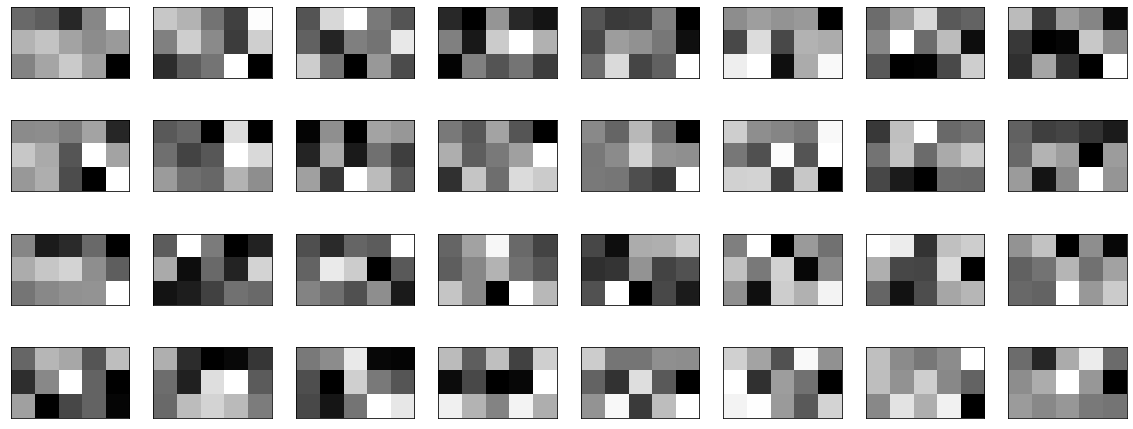

In [ ]:
nchannels = filters.shape[1]
nfilters = filters.shape[2]

# plot the filters 
fig, ax = plt.subplots(4, int(nfilters/4),  figsize=(20,8))
row, column = 0, 0 
for i in range(nfilters):
    # get the filter
    f = filters[:, :, i]

    # plot filter channel in grayscale
    ax[row, column].imshow(f, cmap='gray')
    ax[row, column].get_yaxis().set_visible(False)
    ax[row, column].get_xaxis().set_visible(False)
 
    column += 1
    if column == 8:
        row += 1
        column = 0
        
plt.show()

## Permuation feature importance

Permutation feature importance is a global explainability method that allows you to assess how the different model input features affect the models overall performance. 

To do this, you permute each input feature in turn, this can either be by shuffle the data for feature being assessed (as is done here) or replacing it with a less useful value. Model predictions are then made using this data with a single feature permuted. An evaluation metric is calculated to assess how well the model is able to make predictions with this adjusted input and compared with a baseline (calculated will all data unchanged). This approach is applied for all input features.

In [ ]:
baseline_metric = tf.keras.metrics.KLDivergence()
baseline_metric.update_state(data_splits_test['y_test'], ypred_test_df)
baseline_metric = baseline_metric.result().numpy()

In [ ]:
npermutations=10

In [ ]:
permutation_importance = prd_pipeline.calculate_permutation_feature_importance(model, data_splits_test, feature_dict, baseline_metric, npermutations)

permuting feature: cloud_volume_fraction_in_atmosphere_layer
permuting feature: relative_humidity
permuting feature: air_temperature
permuting feature: wind_from_direction
permuting feature: wind_speed


The change in model's ability to make a prediction is considered the importance of 𝑥:
- If there is a slight decrease when 𝑥 is permuted, 𝑥 is somewhat important
- If there is a large decrease when 𝑥 is permuted, 𝑥 is very important
- If the model can make the same or better predictions when 𝑥 is permuted, 𝑥 is not important

In [ ]:
avg_importance = {}
for k,v in permutation_importance.items():
    avg_importance[k] = np.mean(v)
print(avg_importance)

{'cloud_volume_fraction_in_atmosphere_layer': 0.173213, 'relative_humidity': 0.017342562, 'air_temperature': 0.010391766, 'wind_from_direction': 0.039057266, 'wind_speed': 0.052770235}


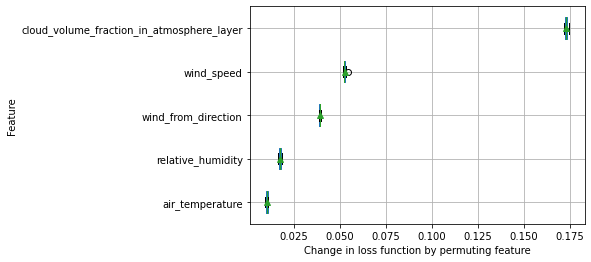

In [ ]:
df = pd.DataFrame(permutation_importance)
df = df.reindex(columns=[k for k, v in sorted(avg_importance.items(), key=lambda item: item[1])])
df.boxplot(showmeans=True, vert=False)
plt.ylabel('Feature')
plt.xlabel('Change in loss function by permuting feature')
plt.show()

One thing you have to be aware of when using this method is correlated input features, when features are correlated are permuted, the performance metric may not drop much as the model can get some of that information from a different feature. So it is important to be cautious with interpretation of results and having some awareness of what is sensible, or input from a domain expert, is useful. 

### Saliency maps

Saliency maps are a local explainability method often used in the field of computer vision. Saliency maps are useful for identify to what extent different parts of the image/array contribute to predictions made by the ML model.

First we select the vertical profile that we to apply this method to. This may a scenario where the ML model and NWP produce very different predictions and we are interested to understand why this could be. 

In [ ]:
sample_idx = np.argmax(data_splits_test['y_test']['radar_fraction_in_band_instant_10.0'])
sample_idx

247734

In [ ]:
img = np.expand_dims(data_splits_test['X_test'][sample_idx], axis=0)
img.shape

(1, 33, 5)

In [ ]:
prof_feature_columns = prd_pipeline.get_profile_columns(feature_dict['profile'], test_scenario.columns)
heights = np.unique([float(column.split('_')[-1]) for column in prof_feature_columns])

We define the name of the final convolutional layer in our neural network, as well as removing the softmax activiation in the final dense layer of the network. 

In [34]:
last_conv_layer_name = 'add_1'
model.layers[-1].activation = None

preds = model.predict(img)
preds

array([[1.9304398e-01, 1.8200237e-01, 6.0750914e-01, 1.7184662e-02,
        2.5989892e-04]], dtype=float32)

We iterate through each of our precipitation intensity bands, which correspond to the classes in our machine learning model, and create a saliency map. We plot the saliency map for each class, with the standardised input features overlaid.

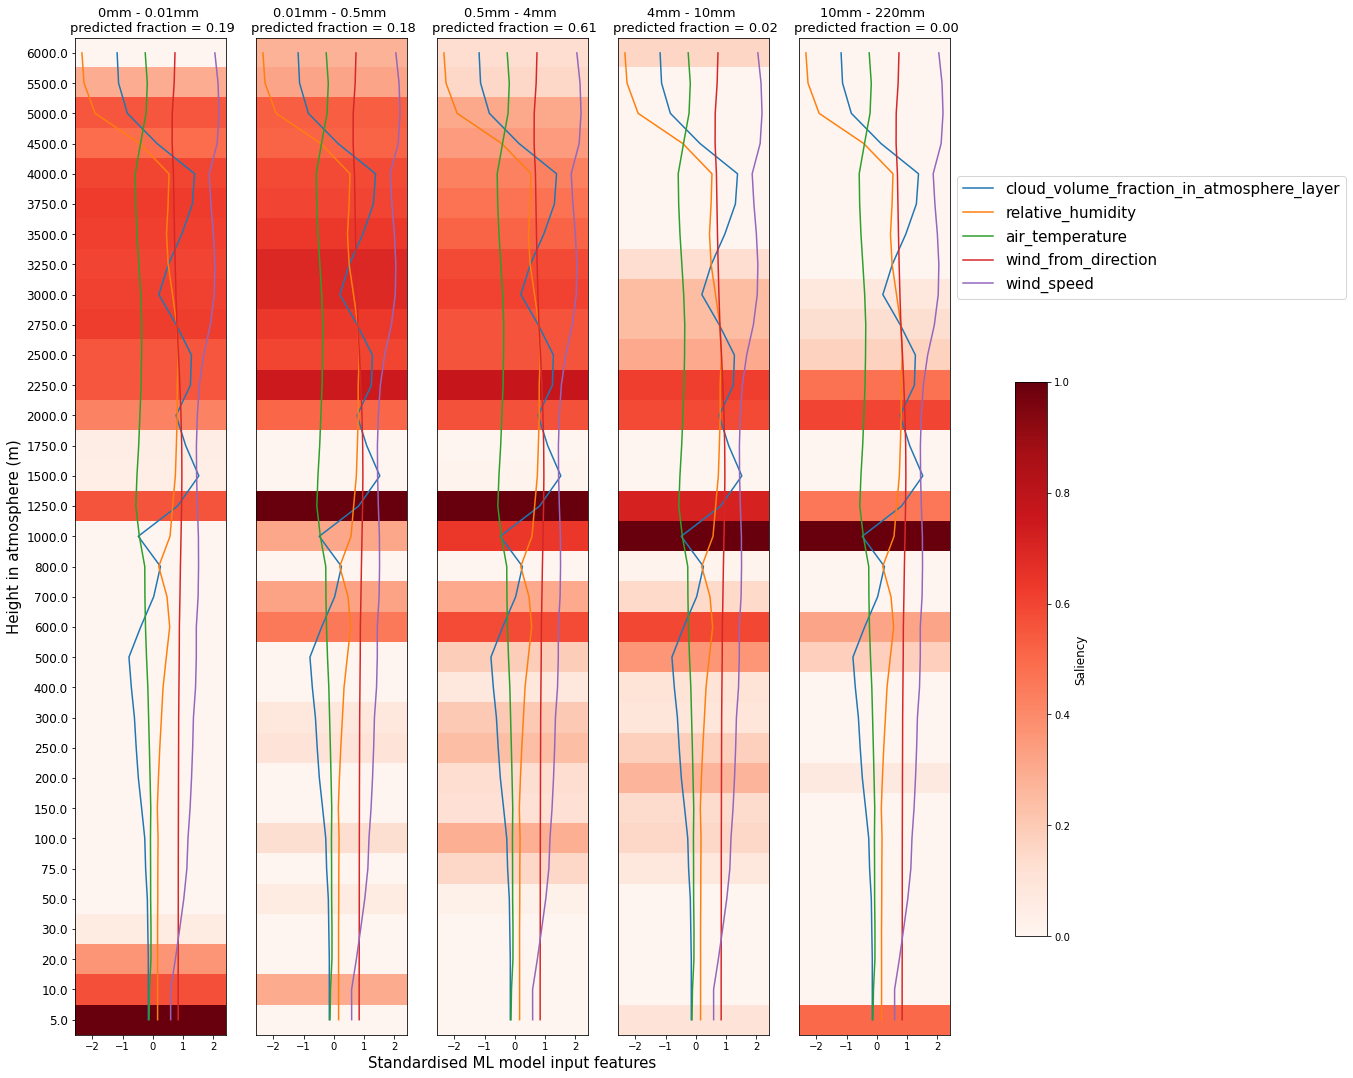

In [36]:
fig, ax = plt.subplots(1, data_dims_dict['nbands'], figsize=(18,22))

for band_idx, band in enumerate(bands):
    # Generate class activation heatmap
    heatmap = prd_pipeline.make_saliency_map(img, model, last_conv_layer_name, pred_index=band_idx)

    ax[band_idx].set_title(f'{bands[band][0]}mm - {bands[band][1]}mm \n predicted fraction = {preds[:,band_idx][0]:.2f}', fontsize=13)
    for i in np.arange(5):
        ax[band_idx].plot(img[0][:,i], np.arange(data_dims_dict['nheights'])+0.5, label=data_splits_test['profile_features_order'][i])
    
    im = ax[band_idx].imshow(heatmap.reshape(data_dims_dict['nheights'], 1), cmap = 'Reds', extent=(ax[band_idx].get_xlim()[0], ax[band_idx].get_xlim()[1], 0, data_dims_dict['nheights']))
    if band_idx != 0:
        ax[band_idx].set_yticks([])
    else: 
        ax[band_idx].set_yticks(np.arange(data_dims_dict['nheights'])+0.5, labels=heights,fontsize=12)
        ax[band_idx].set_ylabel('Height in atmosphere (m)', fontsize=15)
ax[2].set_xlabel('Standardised ML model input features', fontsize=15)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.8), fontsize=15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.025, 0.35])

cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Saliency', fontsize=12)

plt.show()